In [168]:
import os
import numpy as np
import pandas as pd
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
import scipy
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from pandarallel import pandarallel


import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torchvision.transforms import transforms

# Preparations

## Paths

In [2]:
def move_files_to_one_folder():
    import os
    import shutil
    
    folder = r"data"
    subfolders = [f.path for f in os.scandir(folder) if f.is_dir()]
    
    for sub in subfolders:
        for f in os.listdir(sub):
            src = os.path.join(sub, f)
            dst = os.path.join("all_data", f)
            shutil.move(src, dst)

In [3]:
df = pd.DataFrame([f.path for f in os.scandir("all_data")], columns=['path']) 

In [444]:
LABEL_INDEX = 9
df['label'] = df.path.str[LABEL_INDEX].astype(int)

## Spectrograms

In [423]:
def load_and_compute_spectrogram(audio_file):
    # Load files
    y, sr = librosa.load(audio_file, sr=None)

    # Compute spectrograms
    specgram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    specgram_db = librosa.power_to_db(specgram, ref=np.max)

    # Scaling for AlexNet
    minmax = MinMaxScaler((0, 255))

    specgram_db = minmax.fit_transform(specgram_db).astype(np.uint8)
    
    return specgram_db

In [320]:
# parallel computations
pandarallel.initialize(progress_bar=True)
tqdm.pandas()

In [424]:
df["data"] = df.path.parallel_apply(load_and_compute_spectrogram)

### Visualization

* Hard to interpret;

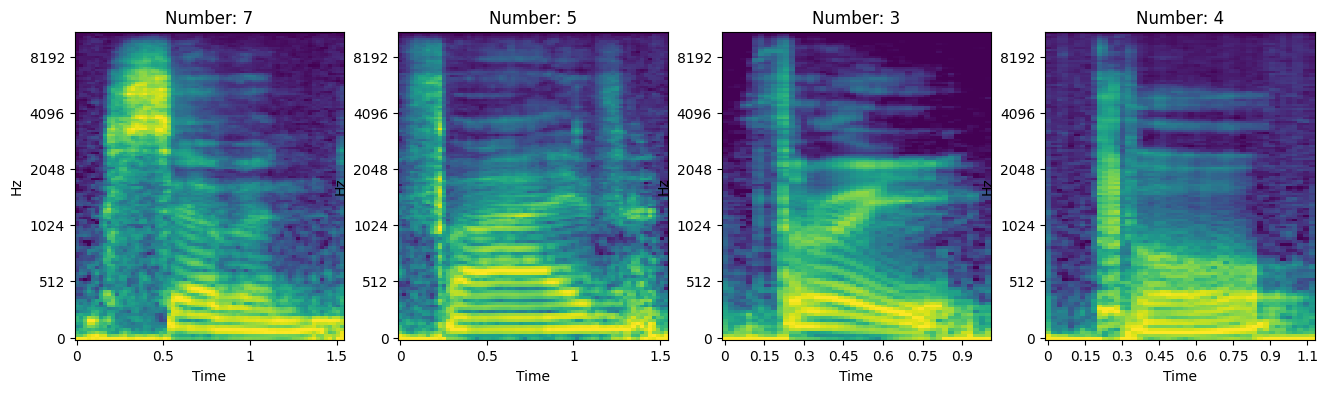

In [471]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

for i in range(4):
    librosa.display.specshow(df.data[i], x_axis='time', y_axis='mel', hop_length=512, cmap='viridis', ax=ax[i])
    ax[i].set_title(f"Number: {df.label[i]}")

plt.show()

## Train test split

In [425]:
train_data, test_data = train_test_split(df.drop(columns=["path"]), test_size=0.1, random_state=42)

# Neural Network

## Create Custom Dataset

In [426]:
class AudioDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None, target_transform=None):
        self.data = df.data
        self.labels = df.label
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Return a single sample at the specified index
        img = Image.fromarray(self.data[index])
        label = torch.tensor(self.labels[index])
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return img, label

# Transforms for data
audio_transforms = transforms.Compose([            
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),                     
    transforms.Resize((224, 224)),                    
    transforms.Normalize(                      
    mean=[0.485, 0.456, 0.406],                
    std=[0.229, 0.224, 0.225]                  
    )
])

train_dataset = AudioDataset(train_data.reset_index(), transform=audio_transforms)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = AudioDataset(test_data.reset_index(), transform=audio_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

## Load AlexNet

In [428]:
model = models.alexnet(pretrained=True)

* Нужно изменить количество выходных классов, чтобы модель корректно делала предсказания;

In [446]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [449]:
NUM_OUTPUT_CLASSES = 10
in_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_features, NUM_OUTPUT_CLASSES)

## Evaluation of pretrained model

* Not the best results: model doesn't "understand" new data;

In [434]:
model.eval()
info = []
y_pred = []
model.to(device)
with torch.no_grad():
    for image, label in tqdm(test_loader):
        image = image.to(device)
        outputs = model(image)
        _, pred = torch.max(outputs, 1)
        info.append(outputs.tolist())
        y_pred.append(pred.item())

100%|██████████████████████████████████████| 3000/3000 [00:15<00:00, 190.37it/s]


In [436]:
y_test = list(test_data.reset_index().label.astype(int))

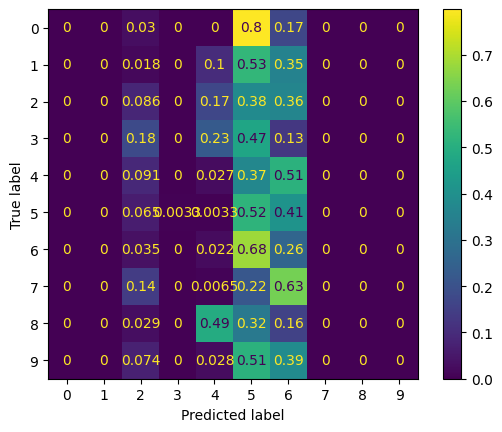

In [439]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true")).plot()

* Running evaluation without tuning is not a good idea, predictions are poor;

## Fine-tuning

* Model works better and understands spectrogram data, mission completed;

In [440]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model.to(device)
model.train()

for images, labels in tqdm(train_loader):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

100%|█████████████████████████████████████████| 844/844 [00:32<00:00, 26.11it/s]


In [441]:
model.eval()
info = []
y_pred = []
model.to(device)
with torch.no_grad():
    for image, label in tqdm(test_loader):
        image = image.to(device)
        outputs = model(image)
        _, pred = torch.max(outputs, 1)
        info.append(outputs.tolist())
        y_pred.append(pred.item())

100%|██████████████████████████████████████| 3000/3000 [00:15<00:00, 188.19it/s]


In [442]:
y_test = list(test_data.reset_index().label.astype(int))

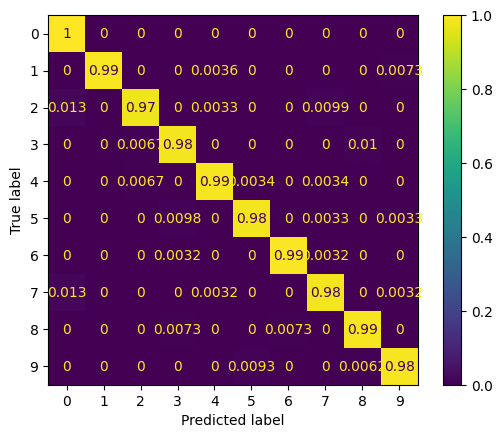

In [443]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred, normalize="true")).plot()